In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import keras
from keras.datasets import cifar10, mnist
from IPython.display import clear_output

(60000, 28, 28, 1)


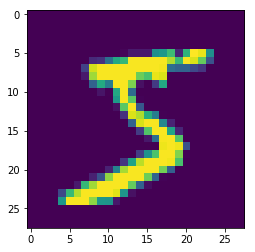

In [35]:
# Get the cifar10 dataset ready
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train,3)

print(x_train.shape)
plt.imshow(x_train[0][:,:,0])
plt.show()

In [57]:
def show_labeled_z_for_batch(z, batch_y):
    for i in range(0, z.shape[0]):
        plt.plot( z[i,0], z[i,1] , '.')
        plt.text( z[i,0], z[i,1], '{}'.format(batch_y[i]) )
    plt.grid()
    plt.xlabel('z0')
    plt.ylabel('z1')
    plt.show()


In [91]:
class VAE:
    def __init__(self, batch_size:int=16, kbase:int=512, layers:int=2, use_batchnorm:bool=False, input_dim:tuple=(28,28,1), z_dim:int=2, sampling_eps_std:float=1, train_drop_rate:float=0.5, name:str='VAE'):
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.name = name
        self.use_batchnorm = use_batchnorm
        self.layers = layers
        self.sampling_eps_std = sampling_eps_std
        self.train_drop_rate = train_drop_rate
        self.kbase = kbase
        self.build_model()
        
    def dense(self, input, units:int, use_bias:bool=True, use_batchnorm:bool=True, use_activation:bool=True, stddev=0.01, name:str='fc'):
        with tf.variable_scope(name) as scope:
            w_init = tf.contrib.layers.variance_scaling_initializer()
            x = tf.layers.batch_normalization(input)
            x = tf.layers.dense(x, units, use_bias=use_bias, kernel_initializer=w_init)
            x = tf.nn.tanh(x)
            return x
            
    def encoder(self, input, layers:int=3, reuse:bool=False, name:str='encoder'):
        with tf.variable_scope(name) as scope:
            if reuse:
                scope.reuse_variables()
                
            input_shape = input.get_shape()
            print('Input shape: {}'.format(input_shape))
            x = tf.reshape(input, shape=[ input_shape[0], np.prod(input_shape[1:]) ], name='x_flat')

            for layer in range(0, layers):
                x = self.dense(x, self.kbase, use_batchnorm=self.use_batchnorm, name='fc{}'.format(layer+1))
                x = tf.nn.dropout(x, self.train_keep_prob, name='fc{}_drop'.format(layer+1))

            z_mean = self.dense(x, units=self.z_dim, use_batchnorm=False, use_activation=False, name='z_mean')
            z_log_sigma = self.dense(x, units=self.z_dim, use_batchnorm=False, use_activation=False, name='z_log_sigma')
            return z_mean, 1e-8+tf.nn.softplus(z_log_sigma)
        
    def decoder(self, input, layers:int=3, reuse:bool=False, name:str='decoder'):
        with tf.variable_scope(name) as scope:
            if reuse:
                scope.reuse_variables()
            x = input
            
            for layer in range(0, layers):
                x = self.dense(x, units=self.kbase, use_batchnorm=self.use_batchnorm, name='fc{}'.format(layer+1))
            
            x = self.dense(x, np.prod(self.input_dim))
            x = tf.reshape(x, shape=[ self.batch_size ] + list(self.input_dim))
            x = tf.nn.sigmoid(x)
            x = tf.clip_by_value(x, 1e-8, 1-1e-8)
            return x
    
    def sampler(self, mean, sigma, reuse:bool=False, name:str='sampler'):
        with tf.variable_scope(name) as scope:
            eps = tf.random_normal(shape=[self.batch_size, self.z_dim], mean=0.0, stddev=self.sampling_eps_std, dtype=tf.float32)
            return mean + sigma*eps
        
    def build_model(self):
        with tf.variable_scope(self.name) as scope:
            self.x = tf.placeholder(tf.float32, shape=[self.batch_size] +list(self.input_dim), name='x')
            self.train_keep_prob = tf.placeholder_with_default(1-self.train_drop_rate, shape=[], name='train_keep_prob')

            # X->Z
            self.z_mean, self.z_sigma = self.encoder(self.x, layers=self.layers)
            
            # Sample from Z
            self.z_sampled = self.sampler(self.z_mean, self.z_sigma)
            
            # Z->Y
            self.y = self.decoder(self.z_sampled, layers=self.layers)

            self.ae_loss = tf.reduce_mean(tf.reduce_sum(tf.pow(self.y-self.x,2), axis=[3,2,1]), axis=0)
            self.z_mean_magn = tf.reduce_mean( tf.reduce_sum( tf.pow(self.z_mean,2),axis=1 ), axis=0 )
            self.z_sigma_magn = tf.reduce_mean( tf.reduce_sum( tf.pow(self.z_sigma,2),axis=1 ), axis=0 )
            
            x_flat = tf.reshape(self.x, [self.batch_size, np.prod(self.input_dim)], name='x_flat')
            y_flat = tf.reshape(self.y, [self.batch_size, np.prod(self.input_dim)], name='y_flat')
            
            marginal_likelihood = tf.reduce_sum( x_flat*tf.log(y_flat) + (1-x_flat)*tf.log(1-y_flat) ,1)
            KL_divergence = 0.5*tf.reduce_sum( tf.square(self.z_mean) + tf.square(self.z_sigma) - tf.log(1e-8 + tf.square(self.z_sigma))-1,1 )

            
            self.loss = -tf.reduce_mean(marginal_likelihood) + tf.reduce_mean(KL_divergence)
            
            self.theta = tf.trainable_variables()
            for t in self.theta:
                print(t)

    def load_weights(self, weights:dict, sess:tf.Session):
        for v in self.theta:
            if( v.name in weights.keys() ):
                print('Loading weights for {}'.format(v.name))
                sess.run( tf.assign( v, weights[v.name] ) )
                
    def get_weights(self, sess:tf.Session):
        weights = dict()
        for v in self.theta:
            weights[v.name] = v.eval() 
        return weights
    
    
                
tf.reset_default_graph()
vae = VAE()   

Input shape: (16, 28, 28, 1)
<tf.Variable 'VAE/encoder/fc1/batch_normalization/gamma:0' shape=(784,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc1/batch_normalization/beta:0' shape=(784,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc1/dense/kernel:0' shape=(784, 512) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc1/dense/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc2/batch_normalization/gamma:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc2/batch_normalization/beta:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc2/dense/kernel:0' shape=(512, 512) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc2/dense/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/z_mean/batch_normalization/gamma:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/z_mean/batch_normalization/beta:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/z_mean/dense/kernel:0' shape=(512, 2) dtype=float32_ref>
<tf.Variable 'VAE/encod

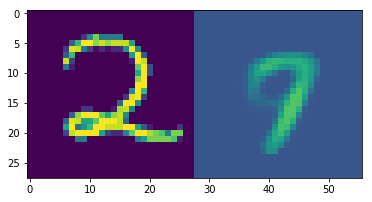

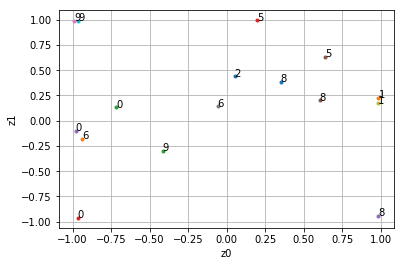

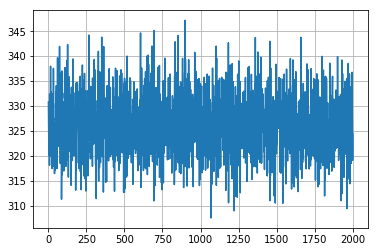

321.65347
324.3521
333.9369
319.77365
329.05316
320.12924
330.8041
328.1213
333.6714
323.2552
318.11108
321.87195
325.98993
322.2194
328.1694
320.24112
328.81598
332.3622
332.19812
322.76315
329.25287
322.00677
329.03854
333.3388
334.60638
314.5806
334.21515
327.84247
316.95193
332.9161
318.77838
318.01944
323.16617
323.19046
319.92172
324.2069
325.132
324.69168
326.10858
320.4635
326.10675
324.36343
332.29297
328.7247
326.79044
322.95413
335.65143
330.84564
318.06857
329.9987
322.32687
325.63858
328.29407
323.1801
329.6501
323.2811
332.0211
330.4195
328.83167
330.59357
324.63824
321.57434
331.73422
323.665
335.29507
325.19925
340.14777
327.8418
326.97833
327.78784
332.7234
326.39487
319.88785
332.49493
324.1129
322.73132
325.29895
321.2225
332.41797
326.52908
333.02472
335.96423
326.58417
323.30707
322.53796
322.36008
316.43903
311.3845
327.19025
325.44055
336.6896
330.8605
332.7547
339.54514
332.6668
333.66962
333.307
332.6742
327.142
328.49863
330.3106
341.6172
329.59525
323.095
340

In [ ]:
vae_optim = tf.train.RMSPropOptimizer(0.00001).minimize( vae.loss, var_list=vae.theta)
it = 0
progress = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    vae.load_weights(weights, sess)
    
    while True:
        idx = np.random.uniform(0, x_train.shape[0], size=(vae.batch_size,)).astype(np.int32)
        batch_x = x_train[idx]/255
        batch_y = y_train[idx]

        _, loss_cur = sess.run([ vae_optim, vae.loss ], feed_dict={ vae.x:batch_x })
        print(loss_cur)
        progress.append([ it, loss_cur ])
        
        if it %500==0:
            weights = vae.get_weights(sess)
            
            clear_output()
            y_pred,z = sess.run( [vae.y, vae.z_mean] , feed_dict={ vae.x:batch_x, vae.train_keep_prob:1.0})
            
            plt.imshow(  np.concatenate([  batch_x[0][:,:,0], y_pred[0][:,:,0]], axis=1)  )
            plt.show()
            
            show_labeled_z_for_batch(z, batch_y)
            
            p = np.array(progress)
            p = p[np.max([0, p.shape[0]-2000]):]
            plt.plot( p[:,0], p[:,1] )
            plt.grid()
            plt.show()
        
        it+=1
        
        

In [90]:
loss_cur

array([585.07263, 563.82855, 574.48157, 570.87085, 583.04584, 566.9988 ,
       578.30164, 578.2959 , 574.8633 , 569.6345 , 584.06915, 593.4041 ,
       572.4617 , 569.644  , 567.5365 , 572.2597 ], dtype=float32)

In [55]:
batch_y

array([7, 2, 0, 7, 1, 6, 7, 8, 7, 1, 1, 2, 3, 4, 7, 4], dtype=uint8)